In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
import logging

import pandas as pd

import core.finance as cofinanc
import core.real_time_example as cretiexa
import dataflow.core as dtfcore
import dataflow.system.real_time_dag_runner as dtfsrtdaru
import dataflow.system.source_nodes as dtfsysonod
import dataflow_amp.pipelines.realtime_etl_data_observer as dtfapredo
import helpers.hasyncio as hasynci
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import market_data.market_data_example as mdmadaex

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-88612250-e26a-4d82-a4a6-499eb675018a.json'
DEBUG Effective logging level=10
DEBUG Shut up 116 modules: botocore.client, botocore.compat, matplotlib, invoke, matplotlib.dates, botocore.awsrequest, matplotlib._constrained_layout, botocore.httpchecksum, botocore.waiter, urllib3.util, botocore.retries.adaptive, matplotlib.axis, boto3.resources.base, urllib3.connection, matplotlib.style.core, botocore.auth, botocore.compress, botocore.regions, botocore.httpsession, botocore.paginate, botocore.response, matplotlib.ticker, botocore.session, matplotlib.mathtext, matplotlib._afm, botocore.credentials, botocore.endpoint, matplotlib.texmanager, matplotlib.category, matplotlib.image, fsspec, asyncio, botocore.retries.standard, boto3.resources, matplotlib.colorbar, boto3.resources.factory, matplotlib.backend_bases, botocore.retries.special, urllib3.connectionpool, botocore.monitoring, m

# Generate synthetic OHLCV data

In [4]:
tz = "America/New_York"
start_datetime = pd.Timestamp("2023-01-03 09:30:00", tz=tz)
end_datetime = pd.Timestamp("2023-01-03 11:30:00", tz=tz)
asset_ids = [101, 201, 301]
bar_duration = "1S"
# TODO(gp): random_ohlcv_bars -> market_data
random_ohlcv_bars = cofinanc.generate_random_ohlcv_bars(
    start_datetime,
    end_datetime,
    asset_ids,
    bar_duration=bar_duration,
)
# random_ohlcv_bars.set_index("end_datetime", inplace=True, drop=True)
# random_ohlcv_bars.index.name = "end_datetime"
# _LOG.debug(hpandas.df_to_str(random_ohlcv_bars))
random_ohlcv_bars.head(10)

DEBUG 1-min bar volatility in bps=77
DEBUG 1-min bar expected count=60000
DEBUG 1-min bar volatility in bps=77
DEBUG 1-min bar expected count=60000
DEBUG 1-min bar volatility in bps=77
DEBUG 1-min bar expected count=60000


,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
3,2023-01-03 09:31:00-05:00,2023-01-03 09:31:01-05:00,2023-01-03 09:31:11-05:00,NaN,NaN,NaN,NaN,NaN,101
4,2023-01-03 09:31:00-05:00,2023-01-03 09:31:01-05:00,2023-01-03 09:31:11-05:00,NaN,NaN,NaN,NaN,NaN,201
5,2023-01-03 09:31:00-05:00,2023-01-03 09:31:01-05:00,2023-01-03 09:31:11-05:00,NaN,NaN,NaN,NaN,NaN,301
6,2023-01-03 09:31:01-05:00,2023-01-03 09:31:02-05:00,2023-01-03 09:31:12-05:00,NaN,NaN,NaN,NaN,NaN,101
7,2023-01-03 09:31:01-05:00,2023-01-03 09:31:02-05:00,2023-01-03 09:31:12-05:00,NaN,NaN,NaN,NaN,NaN,201
8,2023-01-03 09:31:01-05:00,2023-01-03 09:31:02-05:00,2023-01-03 09:31:12-05:00,NaN,NaN,NaN,NaN,NaN,301
9,2023-01-03 09:31:02-05:00,2023-01-03 09:31:03-05:00,2023-01-03 09:31:13-05:00,NaN,NaN,NaN,NaN,NaN,101


# Build a data source node

In [5]:
market_data = random_ohlcv_bars
# # Put the synthetic data into "DataFlow format".
# market_data = random_ohlcv_bars.drop(
#     columns=["start_datetime", "timestamp_db"]
# ).pivot(index="end_datetime", columns="asset_id")
# _LOG.debug(hpandas.df_to_str(market_data)

In [14]:
knowledge_datetime_col_name = "timestamp_db"
# market_data[knowledge_datetime_col_name] = market_data.index
event_loop = None
# event_loop = hasynci._EventLoop()
# asyncio.set_event_loop(event_loop)
replayed_delay_in_mins_or_timestamp = 0
(
    replayed_market_data,
    get_wall_clock_time,
) = mdmadaex.get_ReplayedTimeMarketData_from_df(
    event_loop, replayed_delay_in_mins_or_timestamp, market_data
)

DEBUG min_timestamp=Timestamp('2023-01-03 09:30:59-0500', tz='America/New_York'), max_timestamp=Timestamp('2023-01-03 11:29:59-0500', tz='America/New_York')
DEBUG replayed_delay_in_mins_or_timestamp=0, initial_replayed_timestamp=Timestamp('2023-01-03 09:30:59-0500', tz='America/New_York')
DEBUG self._initial_replayed_timestamp=Timestamp('2023-01-03 09:30:59-0500', tz='America/New_York'), self._initial_wall_clock_dt=Timestamp('2023-11-21 11:04:26.015367-0500', tz='America/New_York')
DEBUG knowledge_datetime_col_name='timestamp_db', delay_in_secs=0


,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
21420,2023-01-03 11:29:59-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,879.15,879.15,879.15,879.15,60260.0,101
21421,2023-01-03 11:29:59-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,1035.01,1035.01,1035.01,1035.01,59852.0,201
21422,2023-01-03 11:29:59-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,1037.89,1037.89,1037.89,1037.89,59878.0,301


DEBUG df=
None
DEBUG asset_id_col='asset_id', asset_ids=[101, 201, 301], start_time_col_name='start_datetime', end_time_col_name='end_datetime', columns=None, get_wall_clock_time=<bound method ReplayedTime.get_wall_clock_time of <core.real_time.ReplayedTime object at 0x7f4c2f1baf10>>, timezone='America/New_York', sleep_in_secs=1.0, time_out_in_secs=120, column_remap=None, filter_data_mode='assert'


In [15]:
timedelta = pd.Timedelta("1T")
# timedelta = pd.Timedelta("1S")
multiindex_output = True
replayed_market_data_node = dtfsysonod.RealTimeDataSource(
    "replayed_market_data",
    replayed_market_data,
    timedelta,
    knowledge_datetime_col_name,
    multiindex_output,
)

# Build a dag builder

In [10]:
dag_builder = dtfapredo.Realtime_etl_DataObserver_DagBuilder()
dag_config = dag_builder.get_config_template()
dag = dag_builder.get_dag(dag_config)
dag.insert_at_head(replayed_market_data_node)

DEBUG name=None, mode='strict'
DEBUG save_node_io='', profile_execution=False, dst_dir=None
DEBUG filter_ath: 
  col_mode: replace_all
  transformer_kwargs: 
    start_time: 09:30:00
    end_time: 16:00:00
resample: 
  in_col_groups: [('close',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 1S
    resampling_groups: [({'close': 'close'}, 'last', {}), ({'close': 'twap'}, 'mean', {})]
    vwap_groups: [('close', 'volume', 'vwap')]
  reindex_like_input: False
  join_output_with_input: False
compute_ret_0: 
  in_col_groups: [('close',), ('vwap',), ('twap',)]
  out_col_group: ()
  transformer_kwargs: 
    mode: log_rets
  col_mapping: 
    close: close.ret_0
    vwap: vwap.ret_0
    twap: twap.ret_0
DEBUG type(DUMMY)=<class 'str'>
DEBUG key=('filter_ath', 'col_mode'), val='replace_all'
DEBUG key=('filter_ath', 'transformer_kwargs', 'start_time'), val=datetime.time(9, 30)
DEBUG key=('filter_ath', 'transformer_kwargs', 'end_time'), val=datetime.time(16, 0)
DEBUG key=('res

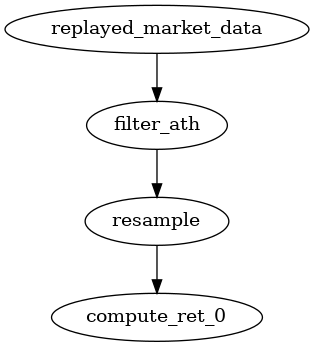

In [11]:
dtfcore.draw(dag)

In [12]:
# # An example DAG execution.
# dag_df_out = dag.run_leq_node("compute_ret_0", "fit")["df_out"]
# _LOG.debug(hpandas.df_to_str(dag_df_out))

# Run DAG

In [ ]:
# Set up the event loop.
bar_duration_in_secs = 60
execute_rt_loop_kwargs = cretiexa.get_replayed_time_execute_rt_loop_kwargs(
    bar_duration_in_secs, event_loop=event_loop
)
# Align on a second boundary.
get_wall_clock_time = lambda: hdateti.get_current_time(
    tz="ET", event_loop=event_loop
)
# creatime.align_on_time_grid(
#     get_wall_clock_time, bar_duration_in_secs, event_loop=event_loop
# )
dag_runner_kwargs = {
    "dag": dag,
    "fit_state": None,
    "execute_rt_loop_kwargs": execute_rt_loop_kwargs,
    "dst_dir": None,
    "get_wall_clock_time": get_wall_clock_time,
    "bar_duration_in_secs": bar_duration_in_secs,
    # We don't want to set the current bar in this test.
    # "set_current_bar_timestamp": False,
    "set_current_bar_timestamp": True,
}
# Run.
dag_runner = dtfsrtdaru.RealTimeDagRunner(**dag_runner_kwargs)
result_bundles = hasynci.run(dag_runner.predict(), event_loop=event_loop)
events = dag_runner.events

DEBUG self._initial_replayed_timestamp=Timestamp('2010-01-04 09:30:00'), self._initial_wall_clock_dt=Timestamp('2023-11-21 09:58:12.872737')
DEBUG _result_nid=compute_ret_0
DEBUG After RealTimeDagRunner ctor: 
<dataflow.system.real_time_dag_runner.RealTimeDagRunner at 0x7f4c2f7c0a90>:
  config='' <core.config.config_.Config>
  _column_to_tags_mapping='None' <NoneType>
  _result_nid='compute_ret_0' <str>
  _execute_rt_loop_kwargs= <dict>
    {'bar_duration_in_secs': 60,
     'get_wall_clock_time': <bound method ReplayedTime.get_wall_clock_time of <core.real_time.ReplayedTime object at 0x7f4c2f7c0d00>>,
     'rt_timeout_in_secs_or_time': 180}
  _dst_dir='None' <NoneType>
  _fit_at_beginning='False' <bool>
  _wake_up_timestamp='None' <NoneType>
  _bar_duration_in_secs='60' <int>
  _set_current_bar_timestamp='True' <bool>
  _max_distance_in_secs='30' <int>
  _events='[]' <list>
DEBUG 
# ################################################################################
# asyncio.run
# #######

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
228,2023-01-03 09:32:15-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,101
229,2023-01-03 09:32:15-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,201
230,2023-01-03 09:32:15-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:16-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(231, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:16-05:00,2023-01-03 09:32:15-05:00,2023-01-03 09:32:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:16-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:16-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=0/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:26.298013-05:00 last_db_end_time=2023-01-03 09:32:16-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:27.429436-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:27.429436-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:27.429436-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:27.429436-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:27.429436-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:27.429436-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
231,2023-01-03 09:32:16-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,101
232,2023-01-03 09:32:16-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,201
233,2023-01-03 09:32:16-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:17-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(234, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:17-05:00,2023-01-03 09:32:16-05:00,2023-01-03 09:32:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:17-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:17-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=1/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:27.428727-05:00 last_db_end_time=2023-01-03 09:32:17-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:28.568397-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:28.568397-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:28.568397-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:28.568397-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:28.568397-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:28.568397-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
234,2023-01-03 09:32:17-05:00,2023-01-03 09:32:18-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,101
235,2023-01-03 09:32:17-05:00,2023-01-03 09:32:18-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,201
236,2023-01-03 09:32:17-05:00,2023-01-03 09:32:18-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:18-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(237, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:18-05:00,2023-01-03 09:32:17-05:00,2023-01-03 09:32:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:18-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:18-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=2/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:28.567470-05:00 last_db_end_time=2023-01-03 09:32:18-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:30.004357-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:30.004357-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:30.004357-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:30.004357-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:30.004357-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:30.004357-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
240,2023-01-03 09:32:19-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,101
241,2023-01-03 09:32:19-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,201
242,2023-01-03 09:32:19-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:20-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(243, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:20-05:00,2023-01-03 09:32:19-05:00,2023-01-03 09:32:30-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:20-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:20-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=3/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:30.003738-05:00 last_db_end_time=2023-01-03 09:32:20-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:31.159207-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:31.159207-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:31.159207-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:31.159207-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:31.159207-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:31.159207-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
243,2023-01-03 09:32:20-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,101
244,2023-01-03 09:32:20-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,201
245,2023-01-03 09:32:20-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:21-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(246, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:21-05:00,2023-01-03 09:32:20-05:00,2023-01-03 09:32:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:21-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:21-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=4/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:31.158905-05:00 last_db_end_time=2023-01-03 09:32:21-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:32.391779-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:32.391779-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:32.391779-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:32.391779-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:32.391779-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:32.391779-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
246,2023-01-03 09:32:21-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,101
247,2023-01-03 09:32:21-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,201
248,2023-01-03 09:32:21-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:22-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(249, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:22-05:00,2023-01-03 09:32:21-05:00,2023-01-03 09:32:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:22-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:22-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=5/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:32.391480-05:00 last_db_end_time=2023-01-03 09:32:22-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:33.622056-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:33.622056-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:33.622056-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:33.622056-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:33.622056-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:33.622056-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
249,2023-01-03 09:32:22-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,101
250,2023-01-03 09:32:22-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,201
251,2023-01-03 09:32:22-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:23-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(252, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:23-05:00,2023-01-03 09:32:22-05:00,2023-01-03 09:32:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:23-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:23-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=6/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:33.621732-05:00 last_db_end_time=2023-01-03 09:32:23-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:34.815358-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:34.815358-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:34.815358-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:34.815358-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:34.815358-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:34.815358-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
252,2023-01-03 09:32:23-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,101
253,2023-01-03 09:32:23-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,201
254,2023-01-03 09:32:23-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:24-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(255, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:24-05:00,2023-01-03 09:32:23-05:00,2023-01-03 09:32:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:24-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:24-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=7/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:34.815000-05:00 last_db_end_time=2023-01-03 09:32:24-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:35.923267-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:35.923267-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:35.923267-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:35.923267-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:35.923267-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:35.923267-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
255,2023-01-03 09:32:24-05:00,2023-01-03 09:32:25-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,101
256,2023-01-03 09:32:24-05:00,2023-01-03 09:32:25-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,201
257,2023-01-03 09:32:24-05:00,2023-01-03 09:32:25-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:25-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(258, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:25-05:00,2023-01-03 09:32:24-05:00,2023-01-03 09:32:35-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:25-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:25-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=8/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:35.922817-05:00 last_db_end_time=2023-01-03 09:32:25-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:37.089584-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:37.089584-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:37.089584-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:37.089584-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:37.089584-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:37.089584-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
261,2023-01-03 09:32:26-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,101
262,2023-01-03 09:32:26-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,201
263,2023-01-03 09:32:26-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:27-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(264, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:27-05:00,2023-01-03 09:32:26-05:00,2023-01-03 09:32:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:27-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:27-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=9/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:37.089271-05:00 last_db_end_time=2023-01-03 09:32:27-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:38.284309-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:38.284309-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:38.284309-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:38.284309-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:38.284309-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:38.284309-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col_

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
264,2023-01-03 09:32:27-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,101
265,2023-01-03 09:32:27-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,201
266,2023-01-03 09:32:27-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:28-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(267, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:28-05:00,2023-01-03 09:32:27-05:00,2023-01-03 09:32:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:28-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:28-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=10/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:38.284022-05:00 last_db_end_time=2023-01-03 09:32:28-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:39.389539-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:39.389539-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:39.389539-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:39.389539-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:39.389539-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:39.389539-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
267,2023-01-03 09:32:28-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,101
268,2023-01-03 09:32:28-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,201
269,2023-01-03 09:32:28-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:29-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(270, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:29-05:00,2023-01-03 09:32:28-05:00,2023-01-03 09:32:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:29-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:29-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=11/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:39.389244-05:00 last_db_end_time=2023-01-03 09:32:29-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:40.545469-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:40.545469-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:40.545469-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:40.545469-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:40.545469-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:40.545469-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
270,2023-01-03 09:32:29-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,101
271,2023-01-03 09:32:29-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,201
272,2023-01-03 09:32:29-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:30-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(273, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:30-05:00,2023-01-03 09:32:29-05:00,2023-01-03 09:32:40-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:30-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:30-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=12/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:40.545172-05:00 last_db_end_time=2023-01-03 09:32:30-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:41.726773-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:41.726773-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:41.726773-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:41.726773-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:41.726773-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:41.726773-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
273,2023-01-03 09:32:30-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,101
274,2023-01-03 09:32:30-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,201
275,2023-01-03 09:32:30-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:31-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(276, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:31-05:00,2023-01-03 09:32:30-05:00,2023-01-03 09:32:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:31-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:31-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=13/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:41.726474-05:00 last_db_end_time=2023-01-03 09:32:31-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:42.953152-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:42.953152-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:42.953152-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:42.953152-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:42.953152-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:42.953152-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
276,2023-01-03 09:32:31-05:00,2023-01-03 09:32:32-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,101
277,2023-01-03 09:32:31-05:00,2023-01-03 09:32:32-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,201
278,2023-01-03 09:32:31-05:00,2023-01-03 09:32:32-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:32-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(279, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:32-05:00,2023-01-03 09:32:31-05:00,2023-01-03 09:32:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:32-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:32-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=14/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:42.952852-05:00 last_db_end_time=2023-01-03 09:32:32-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:44.064835-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:44.064835-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:44.064835-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:44.064835-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:44.064835-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:44.064835-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
282,2023-01-03 09:32:33-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,101
283,2023-01-03 09:32:33-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,201
284,2023-01-03 09:32:33-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:34-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(285, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:34-05:00,2023-01-03 09:32:33-05:00,2023-01-03 09:32:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:34-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:34-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=15/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:44.064454-05:00 last_db_end_time=2023-01-03 09:32:34-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:45.211706-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:45.211706-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:45.211706-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:45.211706-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:45.211706-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:45.211706-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
285,2023-01-03 09:32:34-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,101
286,2023-01-03 09:32:34-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,201
287,2023-01-03 09:32:34-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:35-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(288, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:35-05:00,2023-01-03 09:32:34-05:00,2023-01-03 09:32:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:35-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:35-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=16/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:45.211413-05:00 last_db_end_time=2023-01-03 09:32:35-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:46.343924-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:46.343924-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:46.343924-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:46.343924-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:46.343924-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:46.343924-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
288,2023-01-03 09:32:35-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,101
289,2023-01-03 09:32:35-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,201
290,2023-01-03 09:32:35-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:36-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(291, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:36-05:00,2023-01-03 09:32:35-05:00,2023-01-03 09:32:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:36-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:36-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=17/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:46.343430-05:00 last_db_end_time=2023-01-03 09:32:36-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:47.507035-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:47.507035-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:47.507035-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:47.507035-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:47.507035-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:47.507035-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
291,2023-01-03 09:32:36-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,101
292,2023-01-03 09:32:36-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,201
293,2023-01-03 09:32:36-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:37-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(294, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:37-05:00,2023-01-03 09:32:36-05:00,2023-01-03 09:32:47-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:37-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:37-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=18/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:47.506721-05:00 last_db_end_time=2023-01-03 09:32:37-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:48.597852-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:48.597852-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:48.597852-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:48.597852-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:48.597852-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:48.597852-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
294,2023-01-03 09:32:37-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,101
295,2023-01-03 09:32:37-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,201
296,2023-01-03 09:32:37-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:38-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(297, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:38-05:00,2023-01-03 09:32:37-05:00,2023-01-03 09:32:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:38-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:38-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=19/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:48.597559-05:00 last_db_end_time=2023-01-03 09:32:38-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:49.768848-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:49.768848-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:49.768848-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:49.768848-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:49.768848-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:49.768848-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
297,2023-01-03 09:32:38-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,101
298,2023-01-03 09:32:38-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,201
299,2023-01-03 09:32:38-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:39-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(300, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:39-05:00,2023-01-03 09:32:38-05:00,2023-01-03 09:32:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:39-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:39-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=20/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:49.767860-05:00 last_db_end_time=2023-01-03 09:32:39-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:50.929308-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:50.929308-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:50.929308-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:50.929308-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:50.929308-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:50.929308-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
300,2023-01-03 09:32:39-05:00,2023-01-03 09:32:40-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,101
301,2023-01-03 09:32:39-05:00,2023-01-03 09:32:40-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,201
302,2023-01-03 09:32:39-05:00,2023-01-03 09:32:40-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:40-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(303, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:40-05:00,2023-01-03 09:32:39-05:00,2023-01-03 09:32:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:40-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:40-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=21/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:50.928961-05:00 last_db_end_time=2023-01-03 09:32:40-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:52.042011-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:52.042011-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:52.042011-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:52.042011-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:52.042011-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:52.042011-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
306,2023-01-03 09:32:41-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,101
307,2023-01-03 09:32:41-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,201
308,2023-01-03 09:32:41-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:42-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(309, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:42-05:00,2023-01-03 09:32:41-05:00,2023-01-03 09:32:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:42-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:42-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=22/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:52.041714-05:00 last_db_end_time=2023-01-03 09:32:42-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:53.166618-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:53.166618-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:53.166618-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:53.166618-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:53.166618-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:53.166618-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
309,2023-01-03 09:32:42-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,101
310,2023-01-03 09:32:42-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,201
311,2023-01-03 09:32:42-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:43-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(312, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:43-05:00,2023-01-03 09:32:42-05:00,2023-01-03 09:32:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:43-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:43-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=23/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:53.166313-05:00 last_db_end_time=2023-01-03 09:32:43-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:54.315787-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:54.315787-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:54.315787-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:54.315787-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:54.315787-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:54.315787-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
312,2023-01-03 09:32:43-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,101
313,2023-01-03 09:32:43-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,201
314,2023-01-03 09:32:43-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:44-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(315, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:44-05:00,2023-01-03 09:32:43-05:00,2023-01-03 09:32:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:44-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:44-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=24/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:54.315436-05:00 last_db_end_time=2023-01-03 09:32:44-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:55.511916-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:55.511916-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:55.511916-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:55.511916-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:55.511916-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:55.511916-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
315,2023-01-03 09:32:44-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,101
316,2023-01-03 09:32:44-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,201
317,2023-01-03 09:32:44-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:45-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(318, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:45-05:00,2023-01-03 09:32:44-05:00,2023-01-03 09:32:55-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:45-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:45-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=25/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:55.511460-05:00 last_db_end_time=2023-01-03 09:32:45-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:56.661350-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:56.661350-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:56.661350-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:56.661350-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:56.661350-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:56.661350-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
318,2023-01-03 09:32:45-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,101
319,2023-01-03 09:32:45-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,201
320,2023-01-03 09:32:45-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:46-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(321, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:46-05:00,2023-01-03 09:32:45-05:00,2023-01-03 09:32:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:46-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:46-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=26/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:56.660802-05:00 last_db_end_time=2023-01-03 09:32:46-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:57.812193-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:57.812193-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:57.812193-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:57.812193-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:57.812193-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:57.812193-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
321,2023-01-03 09:32:46-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,101
322,2023-01-03 09:32:46-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,201
323,2023-01-03 09:32:46-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:47-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(324, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:47-05:00,2023-01-03 09:32:46-05:00,2023-01-03 09:32:57-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:47-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:47-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=27/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:57.811853-05:00 last_db_end_time=2023-01-03 09:32:47-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:32:58.925922-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:58.925922-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:32:58.925922-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:32:58.925922-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:32:58.925922-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:32:58.925922-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
324,2023-01-03 09:32:47-05:00,2023-01-03 09:32:48-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,101
325,2023-01-03 09:32:47-05:00,2023-01-03 09:32:48-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,201
326,2023-01-03 09:32:47-05:00,2023-01-03 09:32:48-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:48-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(327, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:48-05:00,2023-01-03 09:32:47-05:00,2023-01-03 09:32:58-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:48-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:48-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=28/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:32:58.925622-05:00 last_db_end_time=2023-01-03 09:32:48-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:00.033050-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:00.033050-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:00.033050-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:00.033050-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:00.033050-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:00.033050-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
330,2023-01-03 09:32:49-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,101
331,2023-01-03 09:32:49-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,201
332,2023-01-03 09:32:49-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:50-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(333, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:50-05:00,2023-01-03 09:32:49-05:00,2023-01-03 09:33:00-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:50-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:50-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=29/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:00.032686-05:00 last_db_end_time=2023-01-03 09:32:50-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:01.152564-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:01.152564-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:01.152564-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:01.152564-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:01.152564-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:01.152564-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
333,2023-01-03 09:32:50-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,101
334,2023-01-03 09:32:50-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,201
335,2023-01-03 09:32:50-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:51-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(336, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:51-05:00,2023-01-03 09:32:50-05:00,2023-01-03 09:33:01-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:51-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:51-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=30/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:01.152175-05:00 last_db_end_time=2023-01-03 09:32:51-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:02.277128-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:02.277128-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:02.277128-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:02.277128-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:02.277128-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:02.277128-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
336,2023-01-03 09:32:51-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,101
337,2023-01-03 09:32:51-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,201
338,2023-01-03 09:32:51-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:52-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(339, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:52-05:00,2023-01-03 09:32:51-05:00,2023-01-03 09:33:02-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:52-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:52-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=31/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:02.276638-05:00 last_db_end_time=2023-01-03 09:32:52-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:03.419843-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:03.419843-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:03.419843-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:03.419843-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:03.419843-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:03.419843-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
339,2023-01-03 09:32:52-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,101
340,2023-01-03 09:32:52-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,201
341,2023-01-03 09:32:52-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:53-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(342, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:53-05:00,2023-01-03 09:32:52-05:00,2023-01-03 09:33:03-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:53-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:53-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=32/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:03.419402-05:00 last_db_end_time=2023-01-03 09:32:53-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:04.573243-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:04.573243-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:04.573243-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:04.573243-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:04.573243-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:04.573243-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
342,2023-01-03 09:32:53-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,101
343,2023-01-03 09:32:53-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,201
344,2023-01-03 09:32:53-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:54-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(345, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:54-05:00,2023-01-03 09:32:53-05:00,2023-01-03 09:33:04-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:54-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:54-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=33/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:04.572690-05:00 last_db_end_time=2023-01-03 09:32:54-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:05.707544-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:05.707544-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:05.707544-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:05.707544-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:05.707544-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:05.707544-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
345,2023-01-03 09:32:54-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,101
346,2023-01-03 09:32:54-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,201
347,2023-01-03 09:32:54-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:55-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(348, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:55-05:00,2023-01-03 09:32:54-05:00,2023-01-03 09:33:05-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:55-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:55-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=34/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:05.707055-05:00 last_db_end_time=2023-01-03 09:32:55-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:06.875828-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:06.875828-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:06.875828-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:06.875828-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:06.875828-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:06.875828-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
348,2023-01-03 09:32:55-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,101
349,2023-01-03 09:32:55-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,201
350,2023-01-03 09:32:55-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:56-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(351, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:56-05:00,2023-01-03 09:32:55-05:00,2023-01-03 09:33:06-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:56-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:56-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=35/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:06.875535-05:00 last_db_end_time=2023-01-03 09:32:56-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:07.993787-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:07.993787-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:07.993787-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:07.993787-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:07.993787-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:07.993787-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
351,2023-01-03 09:32:56-05:00,2023-01-03 09:32:57-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,101
352,2023-01-03 09:32:56-05:00,2023-01-03 09:32:57-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,201
353,2023-01-03 09:32:56-05:00,2023-01-03 09:32:57-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:57-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(354, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:57-05:00,2023-01-03 09:32:56-05:00,2023-01-03 09:33:07-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:57-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:57-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=36/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:07.993492-05:00 last_db_end_time=2023-01-03 09:32:57-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:09.101992-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:09.101992-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:09.101992-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:09.101992-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:09.101992-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:09.101992-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
357,2023-01-03 09:32:58-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,101
358,2023-01-03 09:32:58-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,201
359,2023-01-03 09:32:58-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:32:59-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(360, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:32:59-05:00,2023-01-03 09:32:58-05:00,2023-01-03 09:33:09-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:32:59-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:32:59-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=37/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:09.101415-05:00 last_db_end_time=2023-01-03 09:32:59-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:10.247053-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:10.247053-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:10.247053-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:10.247053-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:10.247053-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:10.247053-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
360,2023-01-03 09:32:59-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:10-05:00,980.1,980.1,980.1,980.1,60348.0,101
361,2023-01-03 09:32:59-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:10-05:00,1020.37,1020.37,1020.37,1020.37,60101.0,201
362,2023-01-03 09:32:59-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:10-05:00,1013.81,1013.81,1013.81,1013.81,59673.0,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,980.1,980.1,980.1,980.1,60348.0,101
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1020.37,1020.37,1020.37,1020.37,60101.0,201
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1013.81,1013.81,1013.81,1013.81,59673.0,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,980.1,980.1,980.1,980.1,60348.0,101
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1020.37,1020.37,1020.37,1020.37,60101.0,201
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1013.81,1013.81,1013.81,1013.81,59673.0,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,980.1,980.1,980.1,980.1,60348.0,101
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1020.37,1020.37,1020.37,1020.37,60101.0,201
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1013.81,1013.81,1013.81,1013.81,59673.0,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:00-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(363, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,980.1,980.1,980.1,980.1,60348.0,101
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1020.37,1020.37,1020.37,1020.37,60101.0,201
2023-01-03 09:33:00-05:00,2023-01-03 09:32:59-05:00,2023-01-03 09:33:10-05:00,1013.81,1013.81,1013.81,1013.81,59673.0,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:00-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:00-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=38/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:10.246759-05:00 last_db_end_time=2023-01-03 09:33:00-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:11.390136-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:11.390136-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:11.390136-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:11.390136-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:11.390136-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:11.390136-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
363,2023-01-03 09:33:00-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,101
364,2023-01-03 09:33:00-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,201
365,2023-01-03 09:33:00-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:01-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(366, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:01-05:00,2023-01-03 09:33:00-05:00,2023-01-03 09:33:11-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:01-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:01-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=39/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:11.389572-05:00 last_db_end_time=2023-01-03 09:33:01-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:12.542816-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:12.542816-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:12.542816-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:12.542816-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:12.542816-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:12.542816-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
366,2023-01-03 09:33:01-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,101
367,2023-01-03 09:33:01-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,201
368,2023-01-03 09:33:01-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:02-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(369, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:02-05:00,2023-01-03 09:33:01-05:00,2023-01-03 09:33:12-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:02-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:02-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=40/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:12.542516-05:00 last_db_end_time=2023-01-03 09:33:02-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:13.675571-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:13.675571-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:13.675571-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:13.675571-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:13.675571-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:13.675571-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
369,2023-01-03 09:33:02-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,101
370,2023-01-03 09:33:02-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,201
371,2023-01-03 09:33:02-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:03-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(372, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:03-05:00,2023-01-03 09:33:02-05:00,2023-01-03 09:33:13-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:03-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:03-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=41/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:13.675270-05:00 last_db_end_time=2023-01-03 09:33:03-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:14.823853-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:14.823853-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:14.823853-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:14.823853-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:14.823853-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:14.823853-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
372,2023-01-03 09:33:03-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,101
373,2023-01-03 09:33:03-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,201
374,2023-01-03 09:33:03-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:04-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(375, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:04-05:00,2023-01-03 09:33:03-05:00,2023-01-03 09:33:14-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:04-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:04-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=42/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:14.823446-05:00 last_db_end_time=2023-01-03 09:33:04-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:15.961923-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:15.961923-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:15.961923-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:15.961923-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:15.961923-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:15.961923-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
375,2023-01-03 09:33:04-05:00,2023-01-03 09:33:05-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,101
376,2023-01-03 09:33:04-05:00,2023-01-03 09:33:05-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,201
377,2023-01-03 09:33:04-05:00,2023-01-03 09:33:05-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:05-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(378, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:05-05:00,2023-01-03 09:33:04-05:00,2023-01-03 09:33:15-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:05-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:05-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=43/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:15.961307-05:00 last_db_end_time=2023-01-03 09:33:05-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:17.083733-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:17.083733-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:17.083733-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:17.083733-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:17.083733-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:17.083733-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
381,2023-01-03 09:33:06-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,101
382,2023-01-03 09:33:06-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,201
383,2023-01-03 09:33:06-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:07-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(384, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:07-05:00,2023-01-03 09:33:06-05:00,2023-01-03 09:33:17-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:07-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:07-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=44/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:17.083414-05:00 last_db_end_time=2023-01-03 09:33:07-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:18.207723-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:18.207723-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:18.207723-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:18.207723-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:18.207723-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:18.207723-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
384,2023-01-03 09:33:07-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,101
385,2023-01-03 09:33:07-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,201
386,2023-01-03 09:33:07-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:08-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(387, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:08-05:00,2023-01-03 09:33:07-05:00,2023-01-03 09:33:18-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:08-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:08-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=45/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:18.207413-05:00 last_db_end_time=2023-01-03 09:33:08-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:19.308141-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:19.308141-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:19.308141-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:19.308141-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:19.308141-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:19.308141-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
387,2023-01-03 09:33:08-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,101
388,2023-01-03 09:33:08-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,201
389,2023-01-03 09:33:08-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:09-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(390, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:09-05:00,2023-01-03 09:33:08-05:00,2023-01-03 09:33:19-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:09-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:09-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=46/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:19.307662-05:00 last_db_end_time=2023-01-03 09:33:09-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:20.446223-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:20.446223-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:20.446223-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:20.446223-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:20.446223-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:20.446223-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
390,2023-01-03 09:33:09-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,101
391,2023-01-03 09:33:09-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,201
392,2023-01-03 09:33:09-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:10-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(393, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:10-05:00,2023-01-03 09:33:09-05:00,2023-01-03 09:33:20-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:10-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:10-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=47/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:20.445620-05:00 last_db_end_time=2023-01-03 09:33:10-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:21.600891-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:21.600891-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:21.600891-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:21.600891-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:21.600891-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:21.600891-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
393,2023-01-03 09:33:10-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,101
394,2023-01-03 09:33:10-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,201
395,2023-01-03 09:33:10-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:11-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(396, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:11-05:00,2023-01-03 09:33:10-05:00,2023-01-03 09:33:21-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:11-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:11-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=48/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:21.599415-05:00 last_db_end_time=2023-01-03 09:33:11-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:22.759139-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:22.759139-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:22.759139-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:22.759139-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:22.759139-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:22.759139-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
396,2023-01-03 09:33:11-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,101
397,2023-01-03 09:33:11-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,201
398,2023-01-03 09:33:11-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:12-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(399, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:12-05:00,2023-01-03 09:33:11-05:00,2023-01-03 09:33:22-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:12-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:12-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=49/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:22.758843-05:00 last_db_end_time=2023-01-03 09:33:12-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:23.917989-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:23.917989-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:23.917989-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:23.917989-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:23.917989-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:23.917989-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
399,2023-01-03 09:33:12-05:00,2023-01-03 09:33:13-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,101
400,2023-01-03 09:33:12-05:00,2023-01-03 09:33:13-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,201
401,2023-01-03 09:33:12-05:00,2023-01-03 09:33:13-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:13-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(402, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:13-05:00,2023-01-03 09:33:12-05:00,2023-01-03 09:33:23-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:13-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:13-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=50/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:23.917682-05:00 last_db_end_time=2023-01-03 09:33:13-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:25.038802-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:25.038802-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:25.038802-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:25.038802-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:25.038802-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:25.038802-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
405,2023-01-03 09:33:14-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,101
406,2023-01-03 09:33:14-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,201
407,2023-01-03 09:33:14-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:15-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(408, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:15-05:00,2023-01-03 09:33:14-05:00,2023-01-03 09:33:25-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:15-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:15-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=51/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:25.038503-05:00 last_db_end_time=2023-01-03 09:33:15-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:26.187044-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:26.187044-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:26.187044-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:26.187044-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:26.187044-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:26.187044-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
408,2023-01-03 09:33:15-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,101
409,2023-01-03 09:33:15-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,201
410,2023-01-03 09:33:15-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:16-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(411, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:16-05:00,2023-01-03 09:33:15-05:00,2023-01-03 09:33:26-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:16-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:16-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=52/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:26.186740-05:00 last_db_end_time=2023-01-03 09:33:16-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:27.363497-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:27.363497-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:27.363497-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:27.363497-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:27.363497-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:27.363497-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
411,2023-01-03 09:33:16-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,101
412,2023-01-03 09:33:16-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,201
413,2023-01-03 09:33:16-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:17-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(414, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:17-05:00,2023-01-03 09:33:16-05:00,2023-01-03 09:33:27-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:17-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:17-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=53/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:27.363116-05:00 last_db_end_time=2023-01-03 09:33:17-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:28.496978-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:28.496978-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:28.496978-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:28.496978-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:28.496978-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:28.496978-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
414,2023-01-03 09:33:17-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,101
415,2023-01-03 09:33:17-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,201
416,2023-01-03 09:33:17-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:18-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(417, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:18-05:00,2023-01-03 09:33:17-05:00,2023-01-03 09:33:28-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:18-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:18-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=54/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:28.496622-05:00 last_db_end_time=2023-01-03 09:33:18-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:29.729923-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:29.729923-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:29.729923-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:29.729923-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:29.729923-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:29.729923-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
417,2023-01-03 09:33:18-05:00,2023-01-03 09:33:19-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,101
418,2023-01-03 09:33:18-05:00,2023-01-03 09:33:19-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,201
419,2023-01-03 09:33:18-05:00,2023-01-03 09:33:19-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:19-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(420, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:19-05:00,2023-01-03 09:33:18-05:00,2023-01-03 09:33:29-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:19-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:19-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=55/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:29.728249-05:00 last_db_end_time=2023-01-03 09:33:19-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:31.016905-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:31.016905-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:31.016905-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:31.016905-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:31.016905-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:31.016905-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
423,2023-01-03 09:33:20-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,101
424,2023-01-03 09:33:20-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,201
425,2023-01-03 09:33:20-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:21-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(426, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:21-05:00,2023-01-03 09:33:20-05:00,2023-01-03 09:33:31-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:21-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:21-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=56/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:31.016595-05:00 last_db_end_time=2023-01-03 09:33:21-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:32.374553-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:32.374553-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:32.374553-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:32.374553-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:32.374553-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:32.374553-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
426,2023-01-03 09:33:21-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,101
427,2023-01-03 09:33:21-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,201
428,2023-01-03 09:33:21-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:22-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(429, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:22-05:00,2023-01-03 09:33:21-05:00,2023-01-03 09:33:32-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:22-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:22-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=57/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:32.374001-05:00 last_db_end_time=2023-01-03 09:33:22-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:33.652927-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:33.652927-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:33.652927-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:33.652927-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:33.652927-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:33.652927-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
429,2023-01-03 09:33:22-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,101
430,2023-01-03 09:33:22-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,201
431,2023-01-03 09:33:22-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:23-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(432, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:23-05:00,2023-01-03 09:33:22-05:00,2023-01-03 09:33:33-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:23-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:23-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=58/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:33.652562-05:00 last_db_end_time=2023-01-03 09:33:23-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:34.969459-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:34.969459-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:34.969459-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:34.969459-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:34.969459-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:34.969459-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
432,2023-01-03 09:33:23-05:00,2023-01-03 09:33:24-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,101
433,2023-01-03 09:33:23-05:00,2023-01-03 09:33:24-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,201
434,2023-01-03 09:33:23-05:00,2023-01-03 09:33:24-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:24-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(435, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:24-05:00,2023-01-03 09:33:23-05:00,2023-01-03 09:33:34-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:24-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:24-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=59/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:34.969005-05:00 last_db_end_time=2023-01-03 09:33:24-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:36.425282-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:36.425282-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:36.425282-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:36.425282-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:36.425282-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:36.425282-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
438,2023-01-03 09:33:25-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,101
439,2023-01-03 09:33:25-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,201
440,2023-01-03 09:33:25-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:26-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(441, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:26-05:00,2023-01-03 09:33:25-05:00,2023-01-03 09:33:36-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:26-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:26-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=60/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:36.424964-05:00 last_db_end_time=2023-01-03 09:33:26-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:37.652716-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:37.652716-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:37.652716-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:37.652716-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:37.652716-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:37.652716-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
441,2023-01-03 09:33:26-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,101
442,2023-01-03 09:33:26-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,201
443,2023-01-03 09:33:26-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:27-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(444, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:27-05:00,2023-01-03 09:33:26-05:00,2023-01-03 09:33:37-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:27-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:27-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=61/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:37.652055-05:00 last_db_end_time=2023-01-03 09:33:27-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:38.815841-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:38.815841-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:38.815841-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:38.815841-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:38.815841-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:38.815841-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
444,2023-01-03 09:33:27-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,101
445,2023-01-03 09:33:27-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,201
446,2023-01-03 09:33:27-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:28-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(447, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:28-05:00,2023-01-03 09:33:27-05:00,2023-01-03 09:33:38-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:28-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:28-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=62/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:38.815452-05:00 last_db_end_time=2023-01-03 09:33:28-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:39.956175-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:39.956175-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:39.956175-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:39.956175-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:39.956175-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:39.956175-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
447,2023-01-03 09:33:28-05:00,2023-01-03 09:33:29-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,101
448,2023-01-03 09:33:28-05:00,2023-01-03 09:33:29-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,201
449,2023-01-03 09:33:28-05:00,2023-01-03 09:33:29-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:29-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(450, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:29-05:00,2023-01-03 09:33:28-05:00,2023-01-03 09:33:39-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:29-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:29-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=63/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:39.955410-05:00 last_db_end_time=2023-01-03 09:33:29-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:41.171844-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:41.171844-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:41.171844-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:41.171844-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:41.171844-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:41.171844-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
453,2023-01-03 09:33:30-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,101
454,2023-01-03 09:33:30-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,201
455,2023-01-03 09:33:30-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:31-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(456, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:31-05:00,2023-01-03 09:33:30-05:00,2023-01-03 09:33:41-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:31-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:31-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=64/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:41.171433-05:00 last_db_end_time=2023-01-03 09:33:31-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:42.284301-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:42.284301-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:42.284301-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:42.284301-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:42.284301-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:42.284301-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
456,2023-01-03 09:33:31-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,101
457,2023-01-03 09:33:31-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,201
458,2023-01-03 09:33:31-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:32-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(459, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:32-05:00,2023-01-03 09:33:31-05:00,2023-01-03 09:33:42-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:32-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:32-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=65/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:42.283994-05:00 last_db_end_time=2023-01-03 09:33:32-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:43.398799-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:43.398799-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:43.398799-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:43.398799-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:43.398799-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:43.398799-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
459,2023-01-03 09:33:32-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,101
460,2023-01-03 09:33:32-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,201
461,2023-01-03 09:33:32-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:33-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(462, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:33-05:00,2023-01-03 09:33:32-05:00,2023-01-03 09:33:43-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:33-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:33-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=66/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:43.398503-05:00 last_db_end_time=2023-01-03 09:33:33-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:44.587373-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:44.587373-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:44.587373-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:44.587373-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:44.587373-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:44.587373-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
462,2023-01-03 09:33:33-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,101
463,2023-01-03 09:33:33-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,201
464,2023-01-03 09:33:33-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:34-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(465, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:34-05:00,2023-01-03 09:33:33-05:00,2023-01-03 09:33:44-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:34-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:34-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=67/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:44.586608-05:00 last_db_end_time=2023-01-03 09:33:34-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:45.745662-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:45.745662-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:45.745662-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:45.745662-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:45.745662-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:45.745662-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
465,2023-01-03 09:33:34-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,101
466,2023-01-03 09:33:34-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,201
467,2023-01-03 09:33:34-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:35-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(468, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:35-05:00,2023-01-03 09:33:34-05:00,2023-01-03 09:33:45-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:35-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:35-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=68/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:45.745339-05:00 last_db_end_time=2023-01-03 09:33:35-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:46.898272-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:46.898272-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:46.898272-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:46.898272-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:46.898272-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:46.898272-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
468,2023-01-03 09:33:35-05:00,2023-01-03 09:33:36-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,101
469,2023-01-03 09:33:35-05:00,2023-01-03 09:33:36-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,201
470,2023-01-03 09:33:35-05:00,2023-01-03 09:33:36-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:36-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(471, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:36-05:00,2023-01-03 09:33:35-05:00,2023-01-03 09:33:46-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:36-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:36-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=69/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:46.897953-05:00 last_db_end_time=2023-01-03 09:33:36-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:48.021987-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:48.021987-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:48.021987-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:48.021987-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:48.021987-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:48.021987-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
474,2023-01-03 09:33:37-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,101
475,2023-01-03 09:33:37-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,201
476,2023-01-03 09:33:37-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:38-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(477, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:38-05:00,2023-01-03 09:33:37-05:00,2023-01-03 09:33:48-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:38-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:38-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=70/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:48.021433-05:00 last_db_end_time=2023-01-03 09:33:38-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:49.161123-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:49.161123-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:49.161123-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:49.161123-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:49.161123-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:49.161123-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
477,2023-01-03 09:33:38-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,101
478,2023-01-03 09:33:38-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,201
479,2023-01-03 09:33:38-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:39-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(480, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:39-05:00,2023-01-03 09:33:38-05:00,2023-01-03 09:33:49-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:39-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:39-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=71/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:49.159644-05:00 last_db_end_time=2023-01-03 09:33:39-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:50.443693-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:50.443693-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:50.443693-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:50.443693-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:50.443693-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:50.443693-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
480,2023-01-03 09:33:39-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,101
481,2023-01-03 09:33:39-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,201
482,2023-01-03 09:33:39-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:40-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(483, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:40-05:00,2023-01-03 09:33:39-05:00,2023-01-03 09:33:50-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:40-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:40-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=72/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:50.443398-05:00 last_db_end_time=2023-01-03 09:33:40-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:51.591931-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:51.591931-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:51.591931-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:51.591931-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:51.591931-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:51.591931-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
483,2023-01-03 09:33:40-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,101
484,2023-01-03 09:33:40-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,201
485,2023-01-03 09:33:40-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:41-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(486, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:41-05:00,2023-01-03 09:33:40-05:00,2023-01-03 09:33:51-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:41-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:41-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=73/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:51.591276-05:00 last_db_end_time=2023-01-03 09:33:41-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:52.743403-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:52.743403-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:52.743403-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:52.743403-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:52.743403-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:52.743403-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
486,2023-01-03 09:33:41-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,101
487,2023-01-03 09:33:41-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,201
488,2023-01-03 09:33:41-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:42-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(489, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:42-05:00,2023-01-03 09:33:41-05:00,2023-01-03 09:33:52-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:42-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:42-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=74/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:52.743049-05:00 last_db_end_time=2023-01-03 09:33:42-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:53.851976-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:53.851976-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:53.851976-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:53.851976-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:53.851976-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:53.851976-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
489,2023-01-03 09:33:42-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,101
490,2023-01-03 09:33:42-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,201
491,2023-01-03 09:33:42-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:43-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(492, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:43-05:00,2023-01-03 09:33:42-05:00,2023-01-03 09:33:53-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:43-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:43-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=75/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:53.851514-05:00 last_db_end_time=2023-01-03 09:33:43-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:54.967531-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:54.967531-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:54.967531-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:54.967531-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:54.967531-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:54.967531-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
492,2023-01-03 09:33:43-05:00,2023-01-03 09:33:44-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,101
493,2023-01-03 09:33:43-05:00,2023-01-03 09:33:44-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,201
494,2023-01-03 09:33:43-05:00,2023-01-03 09:33:44-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
DEBUG get_data_for_interval() columns 'Index(['start_datetime', 'end_datetime', 'timestamp_db', 'open', 'high', 'low', 'close', 'volume', 'asset_id'], dtype='object')'


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _normalize_data=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _convert_timestamps_to_timezone=
None


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _remap_columns=
None
# after get_data=
index=[2023-01-03 09:31:00-05:00, 2023-01-03 09:33:44-05:00]
columns=start_datetime,timestamp_db,open,high,low,close,volume,asset_id
shape=(495, 8)


,start_datetime,timestamp_db,open,high,low,close,volume,asset_id
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2023-01-03 09:31:00-05:00,2023-01-03 09:30:59-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,101
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,201
2023-01-03 09:33:44-05:00,2023-01-03 09:33:43-05:00,2023-01-03 09:33:54-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG None
DEBUG -> ret=2023-01-03 09:33:44-05:00
DEBUG last_end_time=Timestamp('2023-01-03 09:33:44-0500', tz='America/New_York')
DEBUG 
### waiting on last bar: num_iter=76/120: current_bar_timestamp=2023-11-21 09:59:00-05:00 wall_clock_time=2023-01-03 09:33:54.966771-05:00 last_db_end_time=2023-01-03 09:33:44-05:00
DEBUG start_ts=Timestamp('2022-12-27 09:33:56.170087-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:56.170087-0500', tz='America/New_York')
DEBUG start_ts=Timestamp('2022-12-27 09:33:56.170087-0500', tz='America/New_York'), end_ts=Timestamp('2023-01-03 09:33:56.170087-0500', tz='America/New_York'), ts_col_name='start_datetime', asset_ids=[101, 201, 301], left_close=True, right_close=False, limit=None, ignore_delay=False
DEBUG start_timestamp=Timestamp('2022-12-27 09:33:56.170087-0500', tz='America/New_York'), end_timestamp=Timestamp('2023-01-03 09:33:56.170087-0500', tz='America/New_York'), left_close=True, right_close=False
DEBUG knowledge_datetime_col

,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,991.54,991.54,991.54,991.54,59911.0,101
1,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,1000.26,1000.26,1000.26,1000.26,59659.0,201
2,2023-01-03 09:30:59-05:00,2023-01-03 09:31:00-05:00,2023-01-03 09:31:10-05:00,999.95,999.95,999.95,999.95,59607.0,301
,...,...,...,...,...,...,...,...,...
498,2023-01-03 09:33:45-05:00,2023-01-03 09:33:46-05:00,2023-01-03 09:33:56-05:00,NaN,NaN,NaN,NaN,NaN,101
499,2023-01-03 09:33:45-05:00,2023-01-03 09:33:46-05:00,2023-01-03 09:33:56-05:00,NaN,NaN,NaN,NaN,NaN,201
500,2023-01-03 09:33:45-05:00,2023-01-03 09:33:46-05:00,2023-01-03 09:33:56-05:00,NaN,NaN,NaN,NaN,NaN,301


DEBUG -> df after _get_data=
None
